In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from random import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split

FRONTFACE_ALT_CASCADE = "/usr/local/anaconda3/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml"
IMAGES_DIR = "./dataset"

# Common numbers 32 (e.g. CIFAR-10), 64, 96 (e.g. STL-10), or 224 (e.g. common ImageNet ConvNets), 384, and 512.
IMAGE_SIZE = 96
MIN_IMAGE_SIZE = 32

Using TensorFlow backend.


In [2]:
# build a list with label names
label_names = []
with os.scandir(IMAGES_DIR) as it:
    for entry in it:
        if entry.is_dir(): label_names.append(entry.name)

In [3]:
# face detection using cascade classifier    
face_cascade = cv2.CascadeClassifier(FRONTFACE_ALT_CASCADE)

# helper function for face detection and image cropping
def process_image(image):
    processed = []
    if image is not None:
        # APPLY Contrast Limited Adaptive Histogram Equalization (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image = clahe.apply(image)
        # Detect faces in the image using loaded cascade file
        faces = face_cascade.detectMultiScale(image, scaleFactor=1.2, minNeighbors=5, minSize=(MIN_IMAGE_SIZE, MIN_IMAGE_SIZE))
        for (x,y,w,h) in faces:
            cropped = image[y:y+h, x:x+w]
            cropped = cv2.resize(cropped, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
            processed.append(cropped)
    return processed

# helper function for image display
def display(index, data, labels):
    plt.title("Feature index: %d, label: %d, name: %s" % (index, labels[index], label_names[labels[index]]))
    plt.imshow(data[index], cmap="gray")
    plt.show()

In [4]:
# load all images and their corresponding labels
dataset = []
for label in label_names:
#     print("loading label: %s" % label)
    dir_path = os.path.join(IMAGES_DIR, label)
    label_index = label_names.index(label)
    for file_name in tqdm(os.listdir(dir_path)):
        image_path = os.path.join(dir_path, file_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            processed = process_image(image)
            for p_image in processed:
                if p_image is not None: dataset.append([p_image, label_index])

100%|██████████| 202/202 [00:22<00:00, 12.80it/s]


In [5]:
# helper funtion to extract/split train & test data
def extract_train_test_data():
    features = []
    labels = []
    for feature, label in dataset:
        features.append(feature)
        labels.append(label)
    return train_test_split(features, labels, test_size=0.2)

In [6]:
X_train, X_test, y_train, y_test = extract_train_test_data()

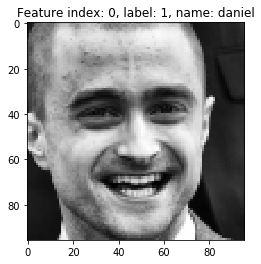

In [7]:
# display sample image from dataset
display(0, X_train, y_train)

In [8]:
# reshape features into vector
X_train = np.array(X_train).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
X_test = np.array(X_test).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

# normalize features
X_train = X_train/255
X_test = X_test/255

print(X_train.shape)

(425, 96, 96, 1)


In [9]:
# make labels categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(y_train.shape)

(425, 4)


In [10]:
# create the model
model = Sequential()

# input layer
model.add(Conv2D(32, (5, 5), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation="relu"))
# model.add(Conv2D(64, (5,5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# aditional convolutional layer
model.add(Conv2D(64, (3, 3), activation="relu"))
# model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten to get a 1D vector and later connecto to fully conected layers
model.add(Flatten())

# fully connected layers
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))

# dropout layer to avoid overfitting
model.add(Dropout(0.3))

# output layer must have the same inputs (# of neurons) as the # of classes to predict
model.add(Dense(4, activation="softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 92, 92, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               7930112   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
__________

In [15]:
# compile model
optimizer = RMSprop(lr=0.0004)
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
# train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Train on 425 samples, validate on 107 samples
Epoch 1/20
425/425 [==============================] - 6s 13ms/step - loss: 0.2636 - acc: 0.9247 - val_loss: 0.3564 - val_acc: 0.8879
Epoch 2/20
425/425 [==============================] - 4s 10ms/step - loss: 0.1237 - acc: 0.9506 - val_loss: 0.3660 - val_acc: 0.8972
Epoch 3/20
425/425 [==============================] - 4s 10ms/step - loss: 0.0527 - acc: 0.9835 - val_loss: 0.5607 - val_acc: 0.8224
Epoch 4/20
425/425 [==============================] - 4s 10ms/step - loss: 0.0598 - acc: 0.9718 - val_loss: 0.3069 - val_acc: 0.9159
Epoch 5/20
425/425 [==============================] - 4s 10ms/step - loss: 0.0230 - acc: 0.9953 - val_loss: 0.3471 - val_acc: 0.9065
Epoch 6/20
425/425 [==============================] - 4s 10ms/step - loss: 0.0139 - acc: 0.9953 - val_loss: 0.4761 - val_acc: 0.8785
Epoch 7/20
425/425 [==============================] - 4s 10ms/step - loss: 0.0321 - acc: 0.9859 - val_loss: 0.5861 - val_acc: 0.8692
Epoch 8/20
425/425 [===

107/107 [==============================] - 0s 2ms/step
[1.169431552708706, 0.8317757003775267]
Error: 16.82%
Loss: 1.17
Accuracy: 83.18%


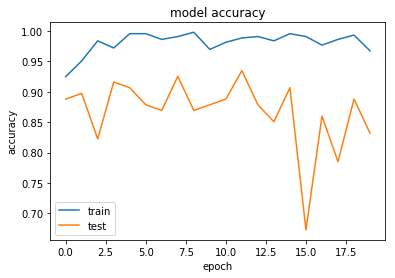

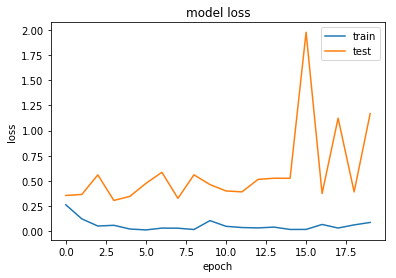

In [17]:
# evaluate the model accuracy
accuracy = model.evaluate(X_test, y_test)
print(accuracy)

print("Error: %.2f%%" % (100-accuracy[1]*100))
print("Loss: %.2f" % accuracy[0])
print("Accuracy: %.2f%%" % (accuracy[1]*100))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()